# App tester
Use this notebook to test app functionalities.

In [2]:
import sys
import numpy as np
import pandas as pd
sys.path.insert(0, "../")
import stockviewer
from stockviewer.eiten import Eiten, save_obj, load_obj

import plotly.io as pio
import plotly.graph_objects as go
pio_template = load_obj("./assets/pio_template_stockviewer")
pio.templates["stockviewer"] = pio_template
pio.templates.default = "stockviewer"

%load_ext autoreload
%autoreload 2

In [40]:
eiten = Eiten(stockviewer.eiten.Args())
eiten.load_data()


--* Eiten has been initialized...

--> Data engine has been initialized...
Loading all stocks from file...
Total number of stocks: 9

--$ Simulator has been initialized

--= Strategy manager has been created...
Genetic algo strategy has been created
Minimum Variance strategy has been created
Eigen portfolio strategy has been created
Maximum sharpe ratio strategy has been created
Helper functions have been created

--# Backtester has been initialized


Loading data for all stocks...


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:03<00:00,  2.44it/s]


In [4]:
# Calculate covariance matrix
covariance_matrix = np.cov(returns_matrix)

# Use random matrix theory to filter out the noisy eigen values
covariance_matrix = eiten.strategyManager.random_matrix_theory_based_cov(
    returns_matrix)

# Get weights for the portfolio
eigen_weights = eiten.strategyManager.calculate_eigen_portfolio(symbol_names, covariance_matrix, eiten.args.eigen_portfolio_number)
mvp_weights = eiten.strategyManager.calculate_minimum_variance_portfolio(symbol_names, covariance_matrix)
msr_weights = eiten.strategyManager.calculate_maximum_sharpe_portfolio(symbol_names, covariance_matrix, predicted_return_vectors)
ga_weights = eiten.strategyManager.calculate_genetic_algo_portfolio(symbol_names, returns_matrix_percentages)

-$ Calculating portfolio weights using eigen values...
-! Calculating portfolio weights using minimum variance portfolio algorithm...
-# Calculating portfolio weights using maximum sharpe portfolio algorithm...
-* Calculating portfolio weights using genetic algorithm...


In [5]:
fig = go.Figure(data=[
    go.Bar(name=strategy, x=symbol_names, y=[strategy_weights[stock] for stock in symbol_names])
    for (strategy, strategy_weights) in zip(["Eigen", "MVP", "MSR", "Genetic"], [eigen_weights, mvp_weights, msr_weights, ga_weights])
])
# Change the bar mode
fig.update_layout(barmode='group', title = "Portfolio weights", xaxis_title = "Stock symbols", yaxis_title = "Weight")
fig.show()

In [6]:
fig = go.Figure()
for (strategy, strategy_weights) in zip(["Eigen", "MVP", "MSR", "Genetic"], [eigen_weights, mvp_weights, msr_weights, ga_weights]):
    # Get market returns during the backtesting time
    historical_price_market_close = list(historical_price_market["Close"])
    market_returns = [eiten.backTester.calculate_percentage_change(historical_price_market_close[i - 1], historical_price_market_close[i]) for i in range(1, len(historical_price_market_close))]
    market_returns_cumulative = np.cumsum(market_returns)

    # Get invidiual returns for each stock in our portfolio
    normal_returns_matrix = []
    for symbol in symbol_names:
        symbol_historical_prices = list(eiten.data_dictionary[symbol]["historical_prices"]["Close"])
        symbol_historical_returns = [eiten.backTester.calculate_percentage_change(symbol_historical_prices[i - 1], symbol_historical_prices[i]) for i in range(1, len(symbol_historical_prices))]
        normal_returns_matrix.append(symbol_historical_returns)

    # Get portfolio returns
    normal_returns_matrix = np.array(normal_returns_matrix).transpose()
    portfolio_weights_vector = np.array([eiten.backTester.portfolio_weight_manager(strategy_weights[symbol], eiten.args.only_long) for symbol in strategy_weights]).transpose()
    portfolio_returns = np.dot(normal_returns_matrix, portfolio_weights_vector)
    portfolio_returns_cumulative = np.cumsum(portfolio_returns)
    
    x = np.arange(len(portfolio_returns_cumulative))
    fig.add_trace(go.Scatter(x = historical_price_market["Date"], y = portfolio_returns_cumulative, mode = "lines", name = strategy))

x = np.arange(len(market_returns_cumulative))
fig.add_trace(go.Scatter(x = historical_price_market["Date"], y = market_returns_cumulative, mode = "lines", line_color = 'white', name = 'Market Index'))
fig.add_hline(y = 0, line_dash="dot", line_color = "white")
fig.update_layout(title = "Strategy backtest (in sample !)", xaxis_title = "Date", yaxis_title = "Return (%)")

In [7]:
fig = go.Figure()
for i, symbol in enumerate(symbol_names):
    symbol_prices = historical_price_info[i]
    fig.add_trace(go.Scatter(x = symbol_prices["Date"], y = symbol_prices["Close"], mode = "lines", name = symbol))
fig.update_layout(title = "Stock evolution", xaxis_title = "Date", yaxis_title = "Stock value")

In [ ]:
eiten.backTester.back_test(symbol_names, eigen_strategy_weights,
                                  eiten.data_dictionary,
                                  historical_price_market_close,
                                  eiten.args.only_long,
                                  market_chart=True,
                                  strategy_name='Eigen Portfolio')
eiten.backTester.back_test(symbol_names,
                          mvp_strategy_weights,
                          eiten.data_dictionary, historical_price_market_close,
                          eiten.args.only_long,
                          market_chart=False,
                          strategy_name='Minimum Variance Portfolio (MVP)')
eiten.backTester.back_test(symbol_names, msr_strategy_weights,
                          eiten.data_dictionary,
                          historical_price_market_close,
                          eiten.args.only_long,
                          market_chart=False,
                          strategy_name='Maximum Sharpe Portfolio (MSR)')
eiten.backTester.back_test(symbol_names,
                          ga_strategy_weights,
                          eiten.data_dictionary,
                          historical_price_market_close,
                          eiten.args.only_long,
                          market_chart=False,
                          strategy_name='Genetic Algo (GA)')

Loading data for all stocks...


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:03<00:00,  2.84it/s]



** Applying random matrix theory to filter out noise in the covariance matrix...

-$ Calculating portfolio weights using eigen values...
-! Calculating portfolio weights using minimum variance portfolio algorithm...
-# Calculating portfolio weights using maximum sharpe portfolio algorithm...
-* Calculating portfolio weights using genetic algorithm...

*% Printing portfolio weights...

-------- Weights for Eigen Portfolio --------
Symbol: AAPL, Weight: -0.0372
Symbol: AMD, Weight: -2.1204
Symbol: AMZN, Weight: -0.0443
Symbol: META, Weight: -0.1106
Symbol: MSFT, Weight: -0.0329
Symbol: NFLX, Weight: 3.3368
Symbol: NVDA, Weight: -0.1304
Symbol: SQQQ, Weight: 0.1012
Symbol: TSLA, Weight: 0.0378

-------- Weights for Minimum Variance Portfolio (MVP) --------
Symbol: AAPL, Weight: 0.1648
Symbol: AMD, Weight: 0.0354
Symbol: AMZN, Weight: 0.1210
Symbol: META, Weight: 0.0543
Symbol: MSFT, Weight: 0.2289
Symbol: NFLX, Weight: 0.0378
Symbol: NVDA, Weight: 0.0518
Symbol: SQQQ, Weight: 0.2887
Symb

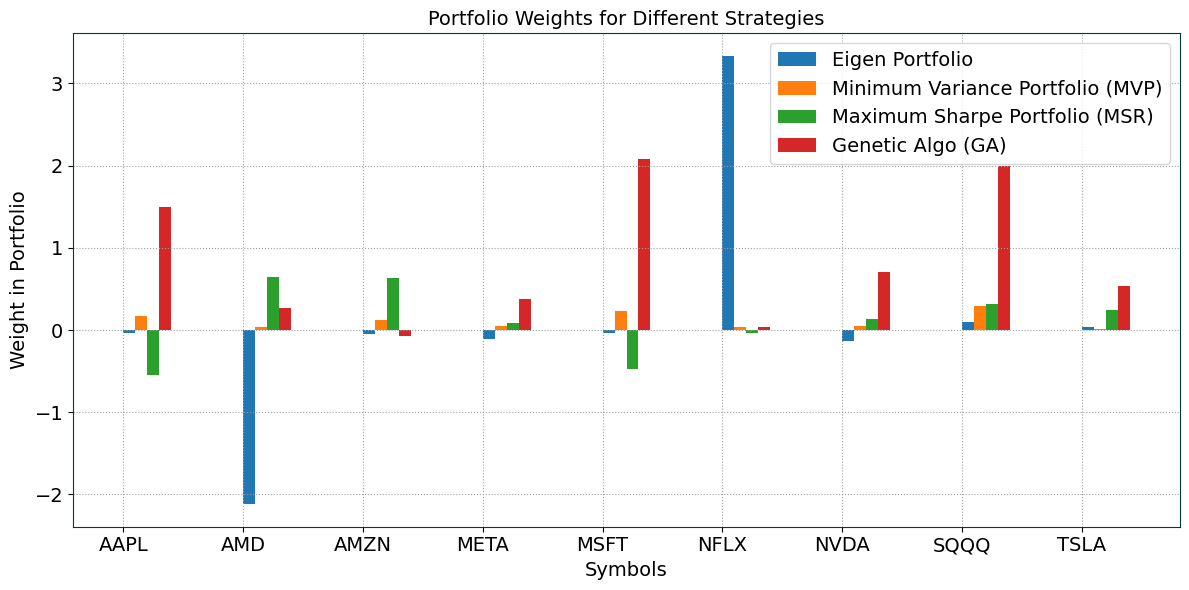


*& Backtesting the portfolios...


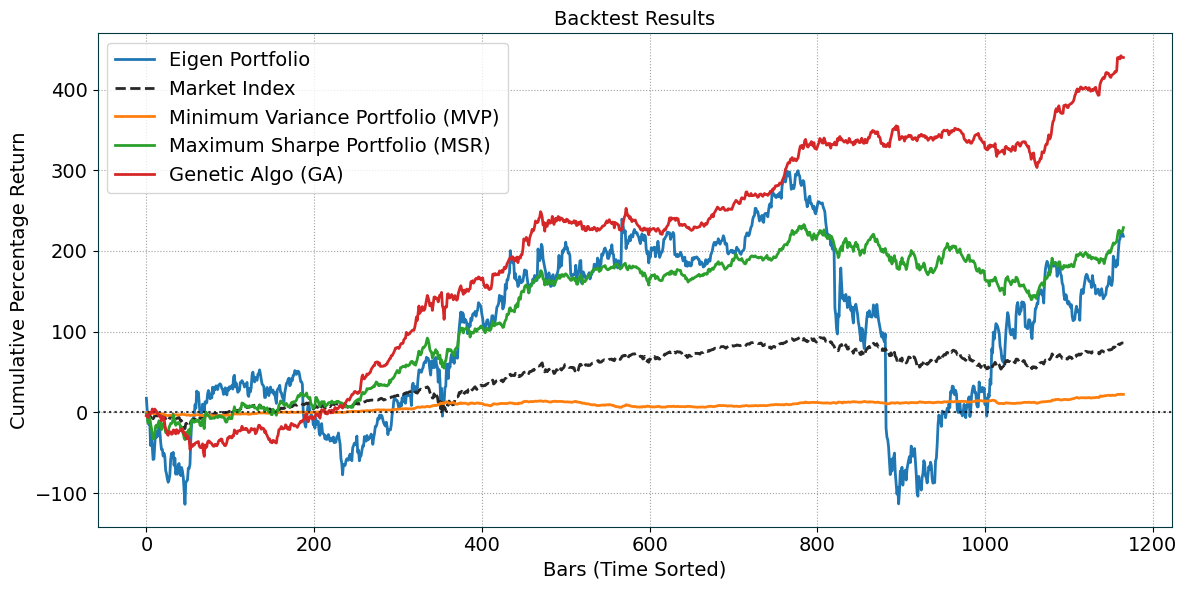


#^ Future testing the portfolios...


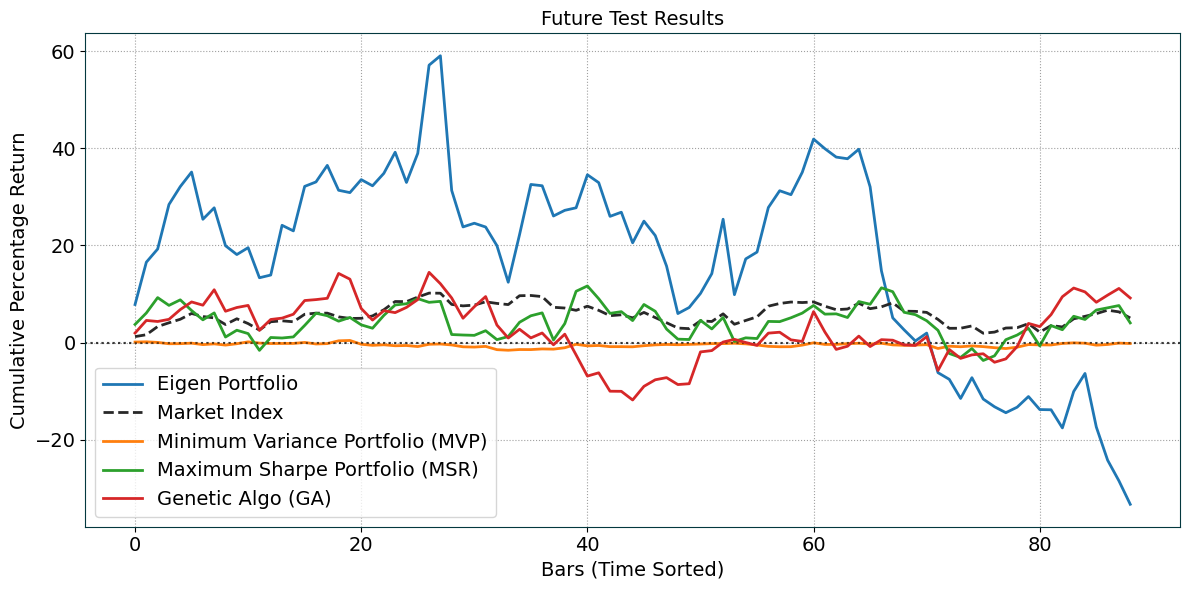


+$ Simulating future prices using monte carlo...


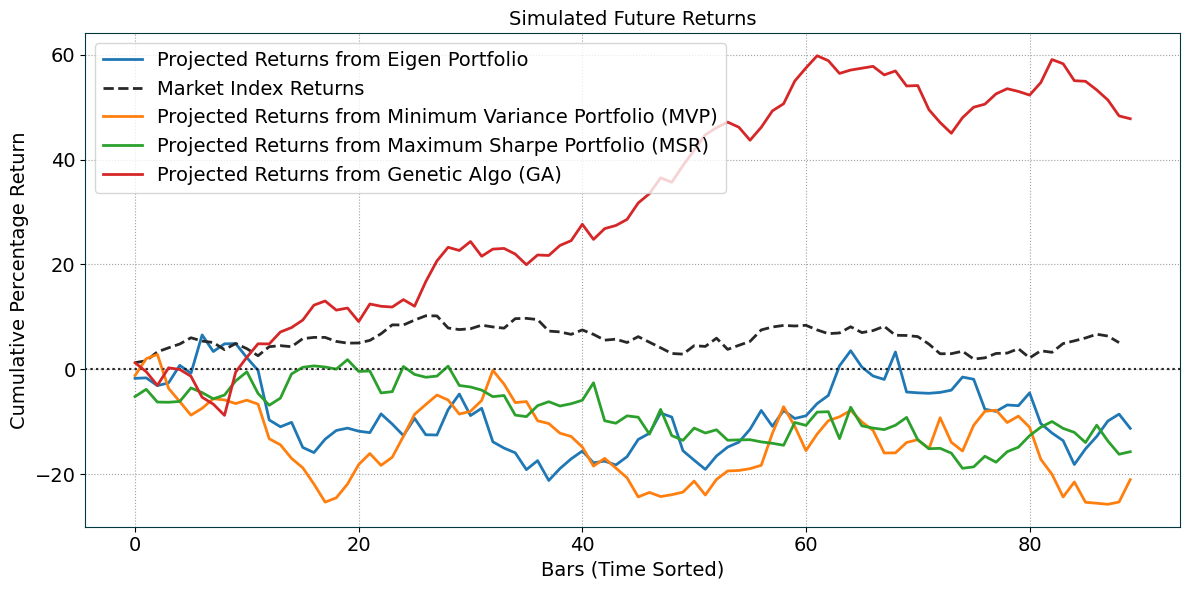

In [11]:
eiten.run_strategies()